# Tree-Based Model & Comparison
Goal: Test whether a non-linear model improves recall and overall separation compared to logistic regression and decide if the added complexity is justified.  

Logistic regression:
* linear
* global decision boundary

Random Forest:
* non-linear
* many decision trees voting together
* captures interactions without manual feature engineering

In [13]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

import matplotlib.pyplot as plt
import seaborn as sns

Load the data:

In [14]:
df = pd.read_csv("../data/credit_default.csv")

# Drop ID column
df.drop(columns=["ID"], inplace=True, errors="ignore")

df.head()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Define features (X) and target (y):

In [15]:
# Set target column
target_col = "default.payment.next.month"

# X is what we know, 
# y is what we want to predict
X = df.drop(columns=[target_col])
y = df[target_col]

X.shape, y.shape


((30000, 23), (30000,))

Train / Test split:

In [16]:
# Split arrays or matrices into random train and test subsets.

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


Let's verify similar distributions for a fair evaluation:

In [17]:
y_train.value_counts(normalize=True)
y_test.value_counts(normalize=True)

default.payment.next.month
0    0.778833
1    0.221167
Name: proportion, dtype: float64

# Build the Random Forest Model

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Define the pipeline:  
* n_estimators=200: 200 trees (100-300 is is a common baseline and more trees mean more stable predictions up to a point)
* random_state=42: controls randomness 
* n_jobs=-1: use all available CPU cores for faster training

Note: Tree models don’t require feature scaling, but helps keep preprocessing consistent across models for comparability

In [19]:
rf_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),  # optional but keeps things consistent
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ))
])

Train:

In [ ]:
rf_pipeline.fit(X_train, y_train)

Let's do some quick verification checks:


In [ ]:
# check that model trained successfully 
rf_pipeline

In [ ]:
# parameters are reasonable
rf_pipeline.named_steps["model"]

Predictions & Evaluation  

Question:  
Did the Random Forest improve our ability to identify defaulters compared to logistic regression?

Make predictions:
* Hard predictions (0 or 1) (Does the model think the customer will default or not?)
* Probabilities (How likely is default?)

In [24]:
y_pred_rf = rf_pipeline.predict(X_test) # yes/no decisions
y_pred_rf_proba = rf_pipeline.predict_proba(X_test)[:, 1] # confidence in default risk

Visualize results:  
Let's use a Confusion Matrix  
* This matrix shows how many predictions were correct and incorrect displaying specific errors 
    * false positives (predicted positive, actually negative)
    * false negatives (predicted negative, actually positive)

True Positives (TP)
* Actual default = 1
* Predicted default = 1
* We caught a defaulter  

False Negatives (FN)
* Actual default = 1
* Predicted no default = 0
* We missed a defaulter → costly 

False Positives (FP)
* Actual no default = 0
* Predicted default = 1
* False alarm

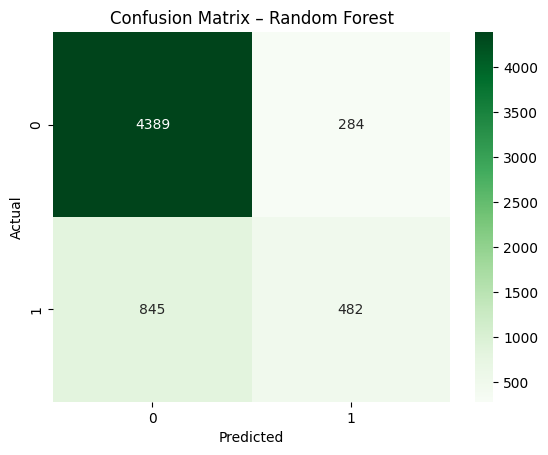

In [25]:
from sklearn.metrics import confusion_matrix

cm_rf = confusion_matrix(y_test, y_pred_rf)

sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()

Compare this matrix to logistic regression:  
* Did true positives (TP) increase? **Yes**  
* Did false negatives (FN) decrease? **Yes**  
* Did false positives increase? **Yes**  

        Fewer FN = better at catching defaulters  


Classification Report:
* Precision → Of everyone flagged as default, how many actually defaulted?
* Recall → Of all the real defaulters, how many did we catch?
* F1 → Balance of precision & recall
* Accuracy → NOT helpful for imbalanced data

What we are looking for:
* Did Recall for class 1 increase?
* Did precision for class 1 drop slightly?
* Did F1 for class 1 improve?

If yes to all, then we are moving in the correct direction

In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4673
           1       0.63      0.36      0.46      1327

    accuracy                           0.81      6000
   macro avg       0.73      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



ROC AUC:  
Evaluates how well a model distinguishes between positive and negative classes.  

AUC measures how well the model separates defaulters from non-defaulters at all thresholds.

Interpretation:
* 0.5 = random guessing
* 0.6–0.7 = weak but usable
* 0.7–0.8 = good
* 0.8+ = very strong

In [27]:
from sklearn.metrics import roc_auc_score

roc_auc_rf = roc_auc_score(y_test, y_pred_rf_proba)
roc_auc_rf


0.7546884239835345

Interpretation

Comparison:  
<mark> Logistic AUC = 0.70 </mark>  
<mark> RF AUC  = 0.75 </mark> 

Higher AUC = better separation between defaulters and non-defaulters.

# Side-by-Side Comparison
| Metric              | Logistic Regression | Random Forest |
| ------------------- | ------------------- | ------------- |
| Recall (default)    |       0.24              |     0.36          |
| Precision (default) |      0.69               |     0.63          |
| ROC-AUC             |        0.70         |       0.75        |


Judgment:

Compared to logistic regression, the Random Forest model increased true positives and reduced false negatives, indicating improved identification of defaulters. While this resulted in a modest increase in false positives, the tradeoff is acceptable given the higher cost of missed defaults.

Random Forest:
* captures non-linear relationships
* learns interactions (e.g., payment history + credit limit)
* can isolate complex risk patterns

Logistic regression:
* draws a single linear boundary
* may miss subtle combinations of risk factors

<mark> The Random Forest is better at saying this combinition ob behaviors is risky vs relying on a single boundary. </mark>